In [1]:
import os
import glob

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf

from src.new_model import *

In [2]:
obj_dims = (648, 486)
BATCH_SIZE = 4
best_is = [676, 569]
# best_is = [676, 569, 457]

test_files = sorted(glob.glob('../data/main_dataset/test/*'))
res_target_path = '../data/real-data/resTargetZ_1.mat'
output_dir = '../results/'
best_images_dir = '../results/best_images'


# Whether to save ground truths to results directory (set False to save time).
save_gts_flag = False

# Load in Test Dataset

In [3]:
def _parse_function(example_proto):
    feature_description = {
        'plane': tf.io.FixedLenFeature(obj_dims, tf.float32),
        'sim': tf.io.FixedLenFeature(obj_dims, tf.float32)
        
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    plane = example['plane']
    plane_max = tf.reduce_max(plane)
    plane_min = tf.reduce_min(plane)
    plane = (plane - plane_min) / (plane_max - plane_min)  # Normalize values to [0, 1]

    sim = example['sim']
    sim_max = tf.reduce_max(sim)
    sim_min = tf.reduce_min(sim)
    sim = (sim - sim_min) / (sim_max - sim_min)  # Normalize values to [0, 1]

    # Expand to channel dimension
    sim = sim[..., tf.newaxis]
    
    return sim, plane

def create_dataset(filenames, batch_size):
    """
    Takes in string array of filenames for TFRecord files containing samples.
    Returns: TFRecordDataset with given batch size
    """
    raw_dataset = tf.data.TFRecordDataset(filenames)
    dataset = raw_dataset.map(_parse_function)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [4]:
test_dataset = create_dataset(test_files, BATCH_SIZE)

# Trained Models

In [5]:
def save_preds_as_png(preds, out_dir):
    """
    Save output of model.predict as pngs.
    Input:
        - preds: numpy array of shape (N, H, W)
        - out_dir: output directory for png images
    """
    preds = np.clip(preds, 0, 1)
    for i in range(preds.shape[0]):
        plt.imshow(preds[i].T, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(out_dir, 'pred_{}.png'.format(i)))
        plt.close('all')

## Save ground truth images

In [6]:
gt_image_dir = os.path.join(output_dir, 'ground_truths')
os.makedirs(gt_image_dir, exist_ok=True)

best_gt_dir = os.path.join(best_images_dir, 'ground_truths')
os.makedirs(best_gt_dir, exist_ok=True)

best_sim_dir = os.path.join(best_images_dir, 'sims')
os.makedirs(best_sim_dir, exist_ok=True)

ground_truths = np.zeros((1000, 648, 486))
best_sims = np.zeros((len(best_is) + 1, 648, 486))

j = 0
for i, (sim, plane) in enumerate(test_dataset.unbatch()):
    ground_truths[i] = plane.numpy()
    if save_gts_flag:
        plt.imshow(plane.numpy().T, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(gt_image_dir, 'gt_{}.png'.format(i)))
        plt.close('all')
    if i in best_is:
        # Save best image ground truth
        plt.imshow(plane.numpy().T, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(best_gt_dir, 'gt_{}.png'.format(i)))
        plt.close('all')
        
        best_sims[j]= sim.numpy().squeeze()
        j += 1
        sim = sim.numpy().squeeze().T
        # Save best image simulations
        plt.imshow(sim, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(best_sim_dir, 'sim_{}.png'.format(i)))
        plt.close('all')
        
        # Save best image sims as MATLAB for use in FISTA
        sio.savemat(os.path.join(best_sim_dir, 'sim_{}.mat'.format(i)), {'b': sim})

# Preprocess resolution target for prediction

In [7]:
res = sio.loadmat(res_target_path)['b']
res = normalize(res).T
res = res.astype(np.float16)[np.newaxis, ..., np.newaxis]

best_sims[-1] = res.squeeze()

## UNet, 9 Learnable Wiener Deconvolutions

In [8]:
test_preds_dir = os.path.join(output_dir, 'unet_multi_wiener/test_preds')
os.makedirs(test_preds_dir, exist_ok=True)

In [9]:
psfs = np.zeros((648, 486, 9))
Ks = np.zeros((1, 1, 9))
model = UNet_multiwiener_resize(648, 486, psfs, Ks,
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])


model.load_weights('../models/model_final_5/model_final_5.best')
preds_multi = np.clip(model.predict(test_dataset), 0, 1)
res_multi = np.clip(model(res), 0, 1).squeeze()

In [10]:
# save_preds_as_png(preds_multi, test_preds_dir)

## UNet, 1 Learnable Wiener Deconvolution

In [11]:
test_preds_dir = os.path.join(output_dir, 'unet_wiener/test_preds')
os.makedirs(test_preds_dir, exist_ok=True)

In [12]:
psf = np.zeros((648, 486))
K = 0
model = UNet_wiener(648, 486, psf, K, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])

model.load_weights('../models/model_final_2/model_final_2.best')
preds_single = np.clip(model.predict(test_dataset), 0, 1)
res_single = np.clip(model(res), 0, 1).squeeze()

In [13]:
# save_preds_as_png(preds_single, test_preds_dir)

# Basic UNet

In [14]:
test_preds_dir = os.path.join(output_dir, 'unet/test_preds')
os.makedirs(test_preds_dir, exist_ok=True)

In [15]:
model = UNet(648, 486,
                 encoding_cs=[24, 64, 128, 256, 512, 1024],
                 center_cs=1024,
                 decoding_cs=[512, 256, 128, 64, 24, 24],
                 skip_connections=[True, True, True, True, True, False])

model.load_weights('../models/model_final_6/model_final_6.best')
preds_unet = np.clip(model.predict(test_dataset), 0, 1)
res_unet = np.clip(model(res), 0, 1).squeeze()

In [16]:
# save_preds_as_png(preds_unet, test_preds_dir)

# FISTA

In [17]:
preds_fista = np.zeros((len(best_is), 648, 486))
# res_fista = sio.loadmat('../results/best_images/recons/recon_res_target.mat')['xhat_out']
res_fista = sio.loadmat('../results/best_images/recons/recon_res_target_5000iters.mat')['xhat_out']


for fista_i, i in enumerate(best_is):
#     preds_fista[fista_i] = sio.loadmat('../results/best_images/recons/recon_{}.mat'.format(i))['xhat_out'].T
    preds_fista[fista_i] = sio.loadmat('../results/best_images/recons/recon_{}_5000iters.mat'.format(i))['xhat_out'].T

# Compute metrics for FISTA separately
psnr_fista = tf.image.psnr(ground_truths[best_is][..., None], preds_fista[..., None], max_val=1.0).numpy()
mse_fista = np.mean((ground_truths[best_is] - preds_fista)**2, axis=(-1, -2))
ssim_fista = tf.image.ssim(tf.convert_to_tensor(ground_truths[best_is][..., None], dtype=tf.float32), 
                           tf.convert_to_tensor(preds_fista[..., None], dtype=tf.float32), max_val=1.0).numpy()

# Compute metrics

In [18]:
# PSNR
psnr_unet = tf.image.psnr(ground_truths[..., None], preds_unet[..., None], max_val=1.0).numpy()
psnr_single = tf.image.psnr(ground_truths[..., None], preds_single[..., None], max_val=1.0).numpy()
psnr_multi = tf.image.psnr(ground_truths[..., None], preds_multi[..., None], max_val=1.0).numpy()

# MSE
mse_unet = np.mean((ground_truths - preds_unet)**2, axis=(-1, -2))
mse_single = np.mean((ground_truths - preds_single)**2, axis=(-1, -2))
mse_multi = np.mean((ground_truths - preds_multi)**2, axis=(-1, -2))

# SSIM
ssim_unet = np.zeros(1000)
ssim_single = np.zeros(1000)
ssim_multi = np.zeros(1000)

k = 10
for i in range(0, 1000, k):
    ssim_unet[i:i+k] = tf.image.ssim(tf.convert_to_tensor(ground_truths[i:i+k][..., None], dtype=tf.float32), tf.convert_to_tensor(preds_unet[i:i+k][..., None], dtype=tf.float32), max_val=1.0).numpy()
    ssim_single[i:i+k] = tf.image.ssim(tf.convert_to_tensor(ground_truths[i:i+k][..., None], dtype=tf.float32), tf.convert_to_tensor(preds_single[i:i+k][..., None], dtype=tf.float32), max_val=1.0).numpy()
    ssim_multi[i:i+k] = tf.image.ssim(tf.convert_to_tensor(ground_truths[i:i+k][..., None], dtype=tf.float32), tf.convert_to_tensor(preds_multi[i:i+k][..., None], dtype=tf.float32), max_val=1.0).numpy()

# Side-by-side Comparisons

In [17]:
test_preds_dir = os.path.join(output_dir, 'comparisons/test_preds')
os.makedirs(test_preds_dir, exist_ok=True)

In [ ]:
# for i in range(preds_unet.shape[0]):
#     fig, axs = plt.subplots(1,4,figsize=(20,10))
    
#     axs[0].imshow(ground_truths[i].T, cmap='gray')
#     axs[3].imshow(preds_unet[i].T, cmap='gray')
#     axs[2].imshow(preds_single[i].T, cmap='gray')
#     axs[1].imshow(preds_multi[i].T, cmap='gray')
    
#     axs[0].set_title('Ground Truth')
#     axs[3].set_title('Basic U-Net')
#     axs[2].set_title('U-Net Wiener')
#     axs[1].set_title('U-Net Multi-Wiener')
    
#     axs[0].set_xticks([])
#     axs[1].set_xticks([])
#     axs[2].set_xticks([])
#     axs[3].set_xticks([])

#     axs[0].set_yticks([])
#     axs[1].set_yticks([])
#     axs[2].set_yticks([])
#     axs[3].set_yticks([])
    
#     axs[3].set_xlabel('SSIM {:.4f}'.format(ssim_unet[i]))
#     axs[2].set_xlabel('SSIM {:.4f}'.format(ssim_single[i]))
#     axs[1].set_xlabel('SSIM {:.4f}'.format(ssim_multi[i]))
    
#     plt.subplots_adjust(wspace=0.02, hspace=0.02)
#     plt.tight_layout()

#     plt.savefig(os.path.join(test_preds_dir, 'comparison_{}.png'.format(i)), facecolor='white', transparent=False)
#     plt.close('all')

# Most significant differences between multi and basic

In [ ]:
test_preds_dir = os.path.join(output_dir, 'comparisons/significant_preds')
os.makedirs(test_preds_dir, exist_ok=True)

In [ ]:
top_ssim_diffs = np.argsort(ssim_multi - ssim_unet)[::-1][:150]
top_psnr_diffs = np.argsort(psnr_multi - psnr_unet)[::-1][0:150]
best_psnr = np.argsort(psnr_multi)[::-1][0:150]
# best_ssim = np.argsort(ssim_multi)[::-1][:300]

In [ ]:
# best_indices = np.intersect1d(top_ssim_diffs, top_psnr_diffs)
# best_indices = np.intersect1d(best_ssim, top_ssim_diffs)
# best_indices = np.intersect1d(best_psnr, top_psnr_diffs)
# best_indices = np.intersect1d(best_ssim, top_psnr_diffs)

best_indices = top_psnr_diffs

In [ ]:
for i in best_indices:
    fig, axs = plt.subplots(1,4,figsize=(20,10))
    
    axs[0].imshow(ground_truths[i].T, vmin=0, vmax=0.5, cmap='inferno')
    axs[3].imshow(preds_unet[i].T, vmin=0, vmax=0.5, cmap='inferno')
    axs[2].imshow(preds_single[i].T, vmin=0, vmax=0.5, cmap='inferno')
    axs[1].imshow(preds_multi[i].T, vmin=0, vmax=0.5, cmap='inferno')
    
    axs[0].set_title('Ground Truth')
    axs[3].set_title('Basic U-Net')
    axs[2].set_title('U-Net Wiener')
    axs[1].set_title('U-Net Multi-Wiener')
    
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[2].set_xticks([])
    axs[3].set_xticks([])

    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[2].set_yticks([])
    axs[3].set_yticks([])
    
    axs[3].set_xlabel('SSIM: {:.4f}\nPSNR: {:.2f}\nMSE: {:.4f}'.format(ssim_unet[i],psnr_unet[i], mse_unet[i]))
    axs[2].set_xlabel('SSIM: {:.4f}\nPSNR: {:.2f}\nMSE: {:.4f}'.format(ssim_single[i],psnr_single[i], mse_single[i]))
    axs[1].set_xlabel('SSIM: {:.4f}\nPSNR: {:.2f}\nMSE: {:.4f}'.format(ssim_multi[i],psnr_multi[i], mse_multi[i]))
    
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    
    plt.tight_layout()
    print(i)
    plt.show()
#     plt.savefig(os.path.join(test_preds_dir, 'comparison_{}.png'.format(i)), facecolor='white', transparent=False)
#     plt.close('all')

# FInal figures

In [19]:
test_preds_dir = os.path.join(output_dir, 'figures')
os.makedirs(test_preds_dir, exist_ok=True)

In [20]:
# best_is = [676, 569, 457]

In [21]:
time_unet = 0.02718
time_single = 0.03144
time_multi = 0.04154
# time_fista = 117.1818
time_fista_5000iters = 60.1822

In [83]:
fig, axs = plt.subplots(len(best_is) + 1, 6, figsize=(1.18 * 648 * 5 * 0.01, 
                                                486 * (len(best_is) + 1) * 0.01))


for j, i in enumerate(best_is):
    axs[j, 0].imshow(normalize(best_sims[j]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    axs[j, 1].imshow(normalize(preds_unet[i]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    axs[j, 2].imshow(normalize(preds_single[i]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    axs[j, 3].imshow(normalize(preds_multi[i]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    axs[j, 4].imshow(normalize(preds_fista[j]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    axs[j, 5].imshow(normalize(ground_truths[i]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    
#     axs[j, 0].set_title('Ground Truth')
#     axs[j, 4].set_title('Basic U-Net')
#     axs[j, 3].set_title('U-Net Wiener')
#     axs[j, 2].set_title('U-Net Multi-Wiener')
#     axs[j, 1].set_title('FISTA')
    
    axs[j, 0].set_xticks([])
    axs[j, 1].set_xticks([])
    axs[j, 2].set_xticks([])
    axs[j, 3].set_xticks([])
    axs[j, 4].set_xticks([])
    axs[j, 5].set_xticks([])

    axs[j, 0].set_yticks([])
    axs[j, 1].set_yticks([])
    axs[j, 2].set_yticks([])
    axs[j, 3].set_yticks([])
    axs[j, 4].set_yticks([])
    axs[j, 5].set_yticks([])
    
    top_y_pad = 50
    right_x_pad = 10
    fontsize = 35
    axs[j, 1].text(right_x_pad, top_y_pad, 'PSNR: {:.3f}'.format(psnr_unet[i]), color='white', fontsize=fontsize)
    axs[j, 2].text(right_x_pad, top_y_pad, 'PSNR: {:.3f}'.format(psnr_single[i]), color='white', fontsize=fontsize)
    axs[j, 3].text(right_x_pad, top_y_pad, 'PSNR: {:.3f}'.format(psnr_multi[i]), color='white', fontsize=fontsize)
    axs[j, 4].text(right_x_pad, top_y_pad, 'PSNR: {:.3f}'.format(psnr_fista[j]), color='white', fontsize=fontsize)
    
# Plot res target predictions
axs[-1, 0].imshow(normalize(best_sims[-1]).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
axs[-1, 1].imshow(normalize(res_unet).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
axs[-1, 2].imshow(normalize(res_single).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
axs[-1, 3].imshow(normalize(res_multi).T, vmin=0, vmax=1, cmap='inferno', aspect='auto')
im = axs[-1, 4].imshow(normalize(res_fista), vmin=0, vmax=1, cmap='inferno', aspect='auto')

axs[-1, 0].set_xticks([])
axs[-1, 1].set_xticks([])
axs[-1, 2].set_xticks([])
axs[-1, 3].set_xticks([])
axs[-1, 4].set_xticks([])

axs[-1, 0].set_yticks([])
axs[-1, 1].set_yticks([])
axs[-1, 2].set_yticks([])
axs[-1, 3].set_yticks([])
axs[-1, 4].set_yticks([])

axs[-1, -1].axis('off')

axs[-1, 1].text(right_x_pad, 465, '{:.2f}s'.format(time_unet), color='white', fontsize=fontsize)
axs[-1, 2].text(right_x_pad, 465, '{:.2f}s'.format(time_single), color='white', fontsize=fontsize)
axs[-1, 3].text(right_x_pad, 465, '{:.2f}s'.format(time_multi), color='white', fontsize=fontsize)
axs[-1, 4].text(right_x_pad, 465, '{:.2f}s'.format(time_fista_5000iters), color='white', fontsize=fontsize)

cbar_ax = fig.add_axes([0.773, 0.125, 0.015, 0.247])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=30)
tick_labels = [0, 0.5, 1.0]
cbar.set_ticks(tick_labels)

for i, label in enumerate(cbar.ax.get_yticklabels()):
    if i == len(tick_labels) - 1:  # top most label
        label.set_va("top")
    elif i == 0:
        label.set_va('bottom')
    else:
        label.set_va("center")

plt.subplots_adjust(wspace=0.02, hspace=0.02)
# plt.show()
plt.savefig(os.path.join(test_preds_dir, 'simulated_comparisons.png'.format(i)), transparent=True)
plt.close('all')

# Metrics averaged across test set

In [24]:
print(np.mean(psnr_multi))
print(np.mean(psnr_single))
print(np.mean(psnr_unet))

23.25438
21.78112
22.626663


In [25]:
print(np.mean(ssim_multi))
print(np.mean(ssim_single))
print(np.mean(ssim_unet))

0.7187441957592964
0.6918580505102873
0.6850629745572805


In [26]:
print(np.mean(mse_multi))
print(np.mean(mse_single))
print(np.mean(mse_unet))

0.007652940104163251
0.010829375486775136
0.009141742191387263


In [39]:
print(ssim_fista)

[0.6812867  0.55263835 0.7622498 ]


In [40]:
print(ssim_multi[best_is])

[0.875992   0.73845774 0.88426065]


In [43]:
print(ssim_single[best_is])

[0.85345662 0.69317228 0.86428857]


In [44]:
print(ssim_unet[best_is])

[0.82411212 0.66104633 0.85754609]


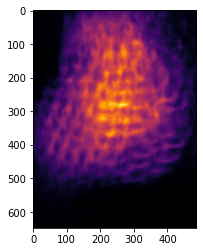

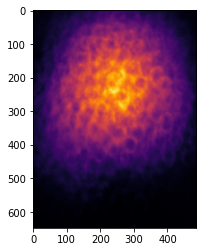

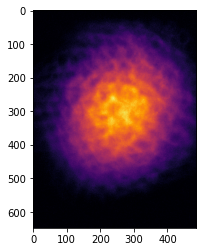

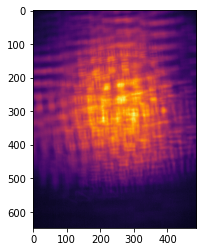

In [65]:
for i in range(best_sims.shape[0]):
    plt.imshow(best_sims[i], vmin=0, vmax=1, cmap='inferno')
    plt.show()